In [2]:
import numpy as np
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.pyplot as mp
import time
from qutip import *
from numpy import sin, cos, sqrt, array, linspace

## Base on Juan Restrepo's paper- 2017
Title: "Fully coupled hybrid cavity optomechanics: Quantum interferences and correlations"

In [ ]:
%%html
<img src='C:/Users/Ahmad/Desktop/2020/photo source/schematic.jpg',width=350, height=220>

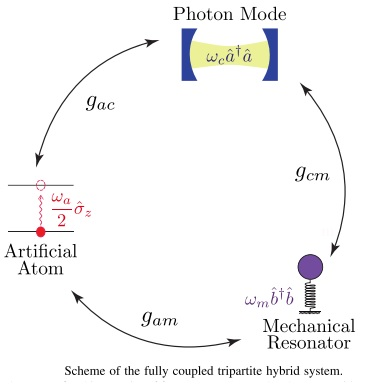

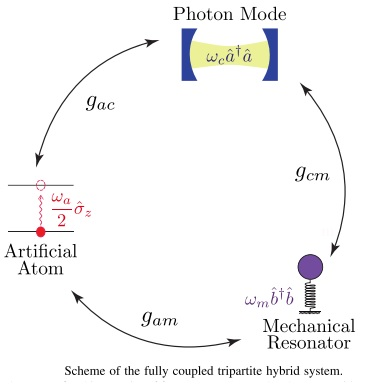

In [3]:
Image(filename='C:/Users/Ahmad/Desktop/2020/photo source/schematic.jpg',width=350, height=220)

### Hamiltonian For this fully coupled syestem:

$\Large \hat{H}_{0}=\omega_{c}\hat{a}^\dagger \hat{a}+ \frac{\omega_{a}}{2}\hat{\sigma}_{z}+\omega_m \hat{b}^\dagger \hat{b} \\
\Large \;\;\;\;\;\;\;\;\;\;\; ig_{ac}(\hat{\sigma}_{+}\hat{a}-\hat{\sigma}_{-}\hat{a}^\dagger) -
 g_{cm}\hat{a}^\dagger \hat{a}(\hat{b}+\hat{b}^\dagger) -
 g_{am} \hat{\sigma}_{z}(\hat{b}+\hat{b}^\dagger)$
 

### Coherent optical deriving and dissipation
Dynamics of the open system following Lindblad master equation

$\frac{d\hat{\rho}}{dt}= -i[\hat{H}_{0}+\hat{V}_{p}(t), \hat{\rho}] \\
  \;\;\;\;\;\;\; +\gamma_{c}L[\hat{a}]\hat{\rho}+\gamma_{a}L[\hat{\sigma}_{-}]\hat{\rho} \\
  \;\;\;\;\;\;\; +n_{th}\gamma_{m}L[\hat{b}^\dagger]
  +(n_{th}+1)\gamma_{m} L[\hat{b}]\hat{\rho}$

Which $\gamma_{m}$,$\gamma_{c}$ and $\gamma_{a}$ are the mechanical, cavity, and atomic
loss rates. $n_{th}$ is the thermal mean phonon occupancy. 

$\hat{V}_{p}(t)$ is coherent optical derive with frequency $\omega_{p}$ and amplitude $F_p$

$\hat{V}_{p}(t)= iF_p (\hat{a}^\dagger e^{i\omega_p t}-\hat{a} e^{-i\omega_p t})$

in order to remove t-dependence of H, we move to the rotating frame via unitary transformation...
Eventually, this is a H:

$ \hat{H}_{0}=\Delta_{cp}\hat{a}^\dagger \hat{a}+ \Delta_{ap}\hat{\sigma}_{z}+\omega_m \hat{b}^\dagger \hat{b} \\
 \;\;\;\;\;\;\; +ig_{ac}(\hat{\sigma}_{+}\hat{a}-\hat{\sigma}_{-}\hat{a}^\dagger) -
 g_{cm}\hat{a}^\dagger \hat{a}(\hat{b}+\hat{b}^\dagger) -
 g_{am} \hat{\sigma}_{z}(\hat{b}+\hat{b}^\dagger) \\
\;\;\;\;\;\;\; + iF_p (\hat{a}^\dagger -\hat{a} ) $

here $\Delta_{cp}=\omega_c- \omega_p$ , and 

$\Delta_{ap}=\omega_a- \omega_p$ OR $\Delta_{ap}=\color{red}{\frac{\omega_a}{2}}- \omega_p$ ??


## Autocorrelation
Here we try to recalculate and visualize result in the main paper
specially Fig. 5 


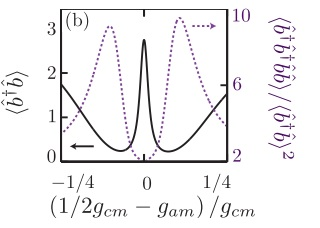

In [2]:
Image(filename='C:/Users/Ahmad/Desktop/2020/Python/g20_Autcr_ SS_03.07.2020/paper3.jpg'\
      ,width=300, height=200)

In [6]:
# parameter values
n_th=3.45               # thermal mean phonon occupancy
wm = 1.0                   #  mechanical frequency
wc = 100 * wm                  # cavity frequency.... 
wa = wc                      # resonance case

gamma_a = wa * 1e-4
gamma_c = gamma_a            # atom loss
gamma_m = wm * 1e-4            # mechanical loss

g_ac = wm/2.0               # atom-cavity coupling strength
g_cm = 0.1 * wm               # cavity-resonator coupling
#g_am =                # atom-resonator coupling

delta_ac = wa - wc        # atom-cavity detuning 
omega_p = wc/2.0 + sqrt((delta_ac**2)/4 + g_ac**2)      # eigenenergies for atom-cavity subsystem
omega_m = wc/2.0 - sqrt((delta_ac**2)/4 + g_ac**2)      # for case which n=1

wp = omega_m  # - wm             # laser frequency
F_p = gamma_c # *100

delta_cp = wc - wp        # cavity-driving detuning
delta_ap = (wa - wp) # * 0.5        # atom-driving detuning   or wa/2 ?

gamma_a/wm

0.01

In [7]:
Pars = {"$ \omega_c$": [wc],"$ \omega_a$": [wa],"$ \omega_m$": [wm],"$ g_{ac} /\omega_m$": [g_ac/wm],\
        "$\gamma_a/\omega_m$" : [gamma_a/wm],"$g_{cm}/\omega_m$" : [g_cm/wm],\
        "$Q_m$" : [wm/gamma_m],"$Q_c$":[wc/gamma_c],"$Q_a$" : [wa/gamma_a],\
        "$F_p/\gamma_a$" : [F_p/gamma_c],"$ \omega_{+}$": [omega_p],\
        "$ \omega_{-}$": [omega_m],"$ \omega_p$": [wp],"$n_{th}$" : [n_th],"$ g_{am}$": "varaible"}
dataa = pd.DataFrame(Pars)
dataa

,$ \omega_c$,$ \omega_a$,$ \omega_m$,$ g_{ac} /\omega_m$,$\gamma_a/\omega_m$,$g_{cm}/\omega_m$,$Q_m$,$Q_c$,$Q_a$,$F_p/\gamma_a$,$ \omega_{+}$,$ \omega_{-}$,$ \omega_p$,$n_{th}$,$ g_{am}$
0,100.0,100.0,1.0,0.5,0.01,0.1,10000.0,10000.0,10000.0,1.0,50.5,49.5,49.5,3.45,varaible


### All the values that are used for this simulation base on above table

In [9]:
Nc = 8     # cavity photon number
Nm = 10     # mechanical phonon number 

a = tensor(qeye(2), qeye(Nm),destroy(Nc))     # cavity anihilation operator
b = tensor(qeye(2), destroy(Nm),qeye(Nc))      # phonon anihilation opr

sigma_z = tensor(sigmaz(), qeye(Nm), qeye(Nc))
sigma_p = tensor(sigmap(), qeye(Nm), qeye(Nc))  # raising and lowering ops for atom
sigma_m = tensor(sigmam(), qeye(Nm), qeye(Nc))
    
collapse = []

rate = gamma_c
if rate > 0.0: 
    collapse.append(a * sqrt(rate))
rate = gamma_a
if rate > 0.0 : 
    collapse.append(sigma_m * sqrt(rate))
rate = n_th * gamma_m
if rate > 0.0: 
    collapse.append(b.dag() * sqrt(rate))
rate = (n_th+1) * gamma_m
if rate > 0.0 : 
    collapse.append(b * sqrt(rate))

expct_op = []
expct_op.append(b.dag()*b)

bdagb = []
g20 = []            # to calculate autocorelation b.dag*b

# defining H as a function of atom-phonon coupling --->> g_am
g_amlist = np.linspace(0.25,0.75,20) * g_cm         # g_am range 

for g_am in g_amlist:
    
    H = (wc-wp) * a.dag() * a + 0.5*(wa-wp) *sigma_z  + (wm) * b.dag() * b \
    + 1j * g_ac * (sigma_p * a - sigma_m * a.dag()) - g_cm * a.dag() * a *(b.dag() + b) \
    - g_am * sigma_z * (b.dag() + b) + 1j* F_p *(a.dag()-a)
    
    rho_ss = steadystate(H, collapse)           # final state for steady state
    
    bdagb.append(expect(b.dag()* b, rho_ss))    # calculate expectation of b.dag*b for steady state 
    g20.append(expect(b.dag()* b.dag()* b * b, rho_ss)/expect (b.dag()*b,rho_ss)**2)


In [12]:
bdagb2= bdagb

In [ ]:
"""
# different approach!
def calculate_rho_ss(g_am): 
    H = delta_cp * a.dag() * a + delta_ap *sigma_z + wm * b.dag() * b \
    + 1j * g_ac * (sigma_p * a - sigma_m * a.dag()) - g_cm * a.dag() * a *(b.dag() + b) \
    - g_am * sigma_z * (b.dag() + b) + 1j* F_p *(a.dag()-a)
    
    return steadystate(H,collapse)

g_amlist = np.linspace(0.25,0.75,10) * g_cm         # g_am range 
start_time=time.time()

rho_ss = parallel_map(calculate_rho_ss, g_amlist )

#bdagb = expect(b.dag() * b , rho_ss)
#g20 = expect(b.dag()* b.dag()* b * b, rho_ss)/bdagb**2
finish_time=time.time()
print('time elapsed = ',finish_time-start_time)
"""

#### Visualize the results

Text(0, 0.5, '$\\langle b^ \\dagger b \\rangle $')

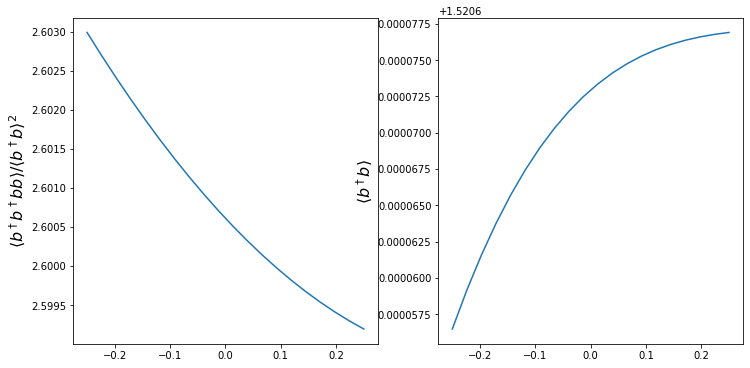

In [13]:
fig, (ax1,ax2)= plt.subplots(1,2,figsize=(12,6))
ax1.plot((g_cm/2.0-g_amlist)/g_cm ,(bdagb))
ax2.plot((g_cm/2.0-g_amlist)/g_cm ,np.real(g20))

ax1.set_ylabel(r'$\langle b^ \dagger b^ \dagger b b \rangle / \langle b^ \dagger b \rangle ^{2} $',fontsize=16)
ax2.set_ylabel(r'$\langle b^ \dagger b \rangle $',fontsize=16)

َAutocorrelation $g^{2}(0)=\langle b^ \dagger b^ \dagger b b \rangle / \langle b^ \dagger b \rangle ^{2}$ 
and steady photon number $\langle a^ \dagger a \rangle $

as a function of pump frequency $\omega_p$

Here we try to recalculate and visualize result in the main paper
specially Fig. 4 

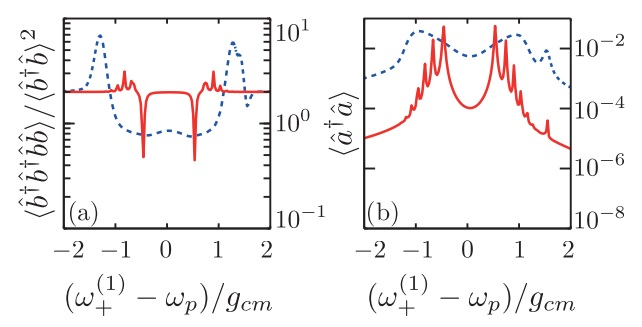

In [14]:
Image(filename='C:/Users/Ahmad/Desktop/2020/Python/g20_Autcr_ SS_03.07.2020/paper4.jpg'\
      ,width=500, height=400)

In [15]:
# parameter values
n_th= 3.45               # thermal mean phonon occupancy
wm = 1.0                   #  mechanical frequency
wc = 100 * wm                  # cavity frequency.... 
wa = wc                      # resonance case
gamma_a = wa * 1e-5
gamma_c = gamma_a            # atom loss
gamma_m = wm * 1e-5            # mechanical loss
g_ac = wm/2.0               # atom-cavity coupling strength
g_cm = 0.1 * wm               # cavity-resonator coupling
g_am = -wm/40.0               # atom-resonator coupling ??

delta_ac = wa - wc        # atom-cavity detuning 
omega_p = wc/2.0 + g_ac      # eigenenergies for atom-cavity subsystem
omega_m = wc/2.0 - g_ac    # for case which n=1

F_p = gamma_c
#delta_cp = wc - wp        # cavity-driving detuning
#delta_ap = (wa - wp) # * 0.5        # atom-driving detuning   or wa/2 ?


In [20]:
Pars = {"$ \omega_c$": [wc],"$ \omega_a$": [wa],"$ \omega_m$": [wm],"$ g_{am} /\omega_m$": [-1/40],\
        "$ g_{ac} /\omega_m$": [g_ac/wm],"$g_{cm}/\omega_m$" : [g_cm/wm],"$\gamma_a/\omega_m$" : [gamma_a/wm],\
        "$Q_m$" : [wm/gamma_m],"$Q_c$":[wc/gamma_c],"$Q_a$" : [wa/gamma_a],\
        "$F_p/\gamma_a$" : [F_p/gamma_c],"$ \omega_{+}$": [omega_p],\
        "$ \omega_{-}$": [omega_m],"$ \omega_p$": "varaible","$n_{th}$" : [n_th]}
dataa = pd.DataFrame(Pars)
dataa

,$ \omega_c$,$ \omega_a$,$ \omega_m$,$ g_{am} /\omega_m$,$ g_{ac} /\omega_m$,$g_{cm}/\omega_m$,$\gamma_a/\omega_m$,$Q_m$,$Q_c$,$Q_a$,$F_p/\gamma_a$,$ \omega_{+}$,$ \omega_{-}$,$ \omega_p$,$n_{th}$
0,100.0,100.0,1.0,-0.025,0.5,0.1,0.001,100000.0,100000.0,100000.0,1.0,50.5,49.5,varaible,3.45


### All the values that are used for this simulation base on above table

In [23]:
2*g_cm+omega_p
#omega_p-2*g_cm

50.7

In [24]:
Nc = 9     # cavity photon number
Nm = 9     # mechanical phonon number 

a = tensor(qeye(2), qeye(Nm),destroy(Nc))     # cavity anihilation operator
b = tensor(qeye(2), destroy(Nm),qeye(Nc))      # phonon anihilation opr

sigma_z = tensor(sigmaz(), qeye(Nm), qeye(Nc))
sigma_p = tensor(sigmap(), qeye(Nm), qeye(Nc))  # raising and lowering ops for atom
sigma_m = tensor(sigmam(), qeye(Nm), qeye(Nc))
    
collapse = []
rate = gamma_c
if rate > 0.0: 
    collapse.append(a * sqrt(rate))
rate = gamma_a
if rate > 0.0 : 
    collapse.append(sigma_m * sqrt(rate))
rate = n_th * gamma_m
if rate > 0.0: 
    collapse.append(b.dag() * sqrt(rate))
rate = (n_th+1) * gamma_m
if rate > 0.0 : 
    collapse.append(b * sqrt(rate))

adaga = []
g20 = []            # to calculate autocorelation b.dag*b

# defining H as a function of atom-phonon coupling --->> g_am
wp_list = np.linspace(50.2,50.9,100)              # laser frequency range      

for wp in wp_list:
    
    H = (wc - wp) * a.dag() * a +0.5*(wa-wp) *sigma_z  + (wm) * b.dag() * b \
    + 1j * g_ac * (sigma_p * a - sigma_m * a.dag()) - g_cm * a.dag() * a *(b.dag() + b) \
    - g_am * sigma_z * (b.dag() + b) + 1j* F_p *(a.dag()-a)
    
    rho_ss = steadystate(H, collapse)           # final state for steady state
    
    adaga.append(expect(a.dag()* a, rho_ss))    # calculate expectation of b.dag*b for steady state 
    g20.append(expect(b.dag()* b.dag()* b * b, rho_ss)/expect (b.dag()*b,rho_ss)**2)

#### Visualize the results

Text(0, 0.5, '$\\langle a^ \\dagger a \\rangle $')

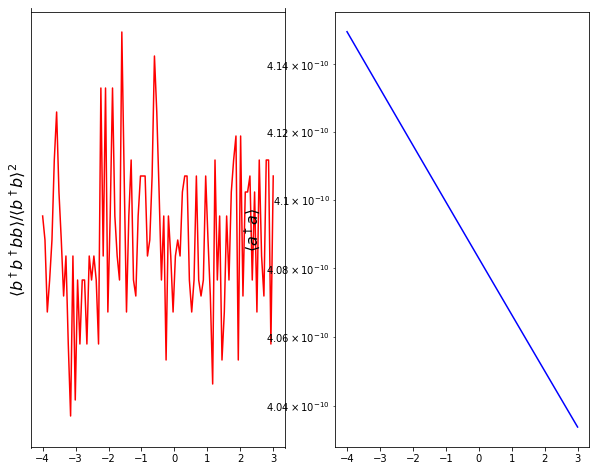

In [25]:
fig, ax= plt.subplots(1,2,figsize=(10,8))
ax[0].plot((omega_p-wp_list)/g_cm ,np.real(g20),'r')
ax[1].plot((omega_p-wp_list)/g_cm ,np.real(adaga),'b')

#plt.semilogy((omega_p-wp_list)/g_cm ,np.real(g20))
#plt.semilogy((omega_p-wp_list)/g_cm ,np.real(adaga))
ax[0].set_yscale('log')
ax[1].set_yscale('log')

ax[0].set_ylabel(r'$\langle b^ \dagger b^ \dagger b b \rangle / \langle b^ \dagger b \rangle ^{2} $',fontsize=16)
ax[1].set_ylabel(r'$\langle a^ \dagger a \rangle $',fontsize=16)